In [1]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging

from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
import os

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available else "cpu"
torch_device

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [4]:
#loading all components

#vae
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

#tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

#unet
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

#all to gpu
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


C:\Users\TYC\AppData\Local\Temp\ipykernel_15924\2138708465.py:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [03:10<00:00,  6.36s/it]


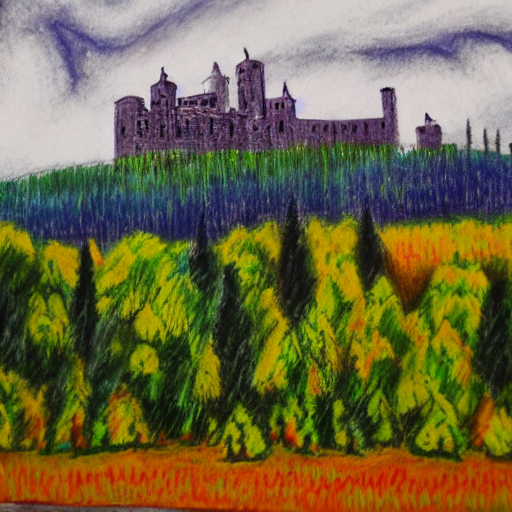

In [10]:
#diffusion loop

prompt = ["An oil pastel painting of a rural Bavarian mountianous forest with castles and foliage"]
height = 512
width = 512
num_inference_steps = 30
guidance_scale = 7.5
generator = torch.manual_seed(32)
batch_size = 1

#preparing text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#preparing scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler, num_inference_steps)

#preparing latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma #scaling

#sampling loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

        #expand
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        #predict
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        #guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)  

        #x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

#scale and decode
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

#display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

pil_images[0]




In [12]:
#vae property
def pil_to_latent(input_im):
    #to (1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1) #scale

    return 0.18215 * latent.latent_dist.sample()

def latent_to_pil(latents):
    latents = (1 / 0.18215) * latents

    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    return pil_images

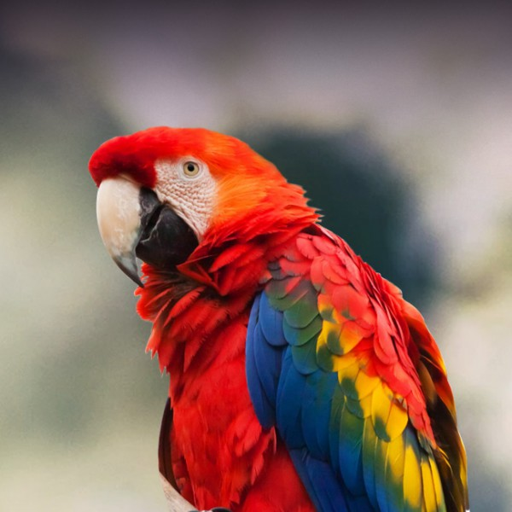

In [15]:
#download
import requests
from io import BytesIO

url = 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'
def download_image(url):
    
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

input_image = download_image(url).resize((512, 512))
input_image 

In [17]:
#try vae
#encode
encoded = pil_to_latent(input_image)
print(encoded.shape)

torch.Size([1, 4, 64, 64])


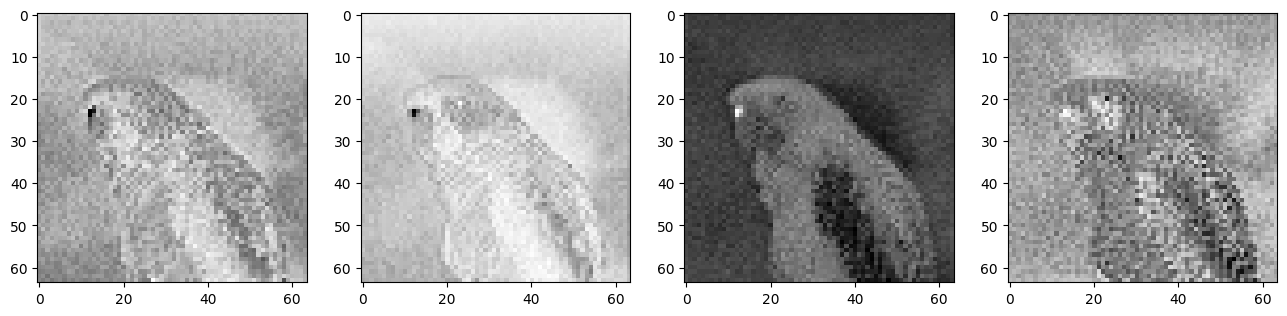

In [18]:
#look at the 4 encoded channels
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

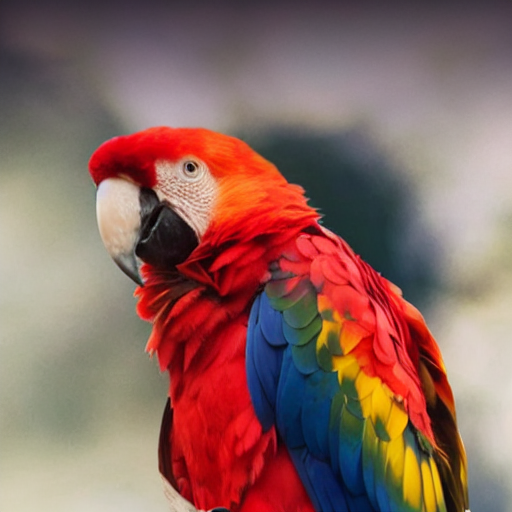

In [19]:
#decode back
decoded = latent_to_pil(encoded)[0]
decoded